In [1]:
from __future__ import print_function
from keras.layers import Input, Dense, Lambda
from keras.models import Model
import tensorflow as tf
from keras import backend as K

from keras import regularizers

#from __future__ import division
from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt

from keras import optimizers
from keras.utils import to_categorical

from keras import callbacks
import copy

Using TensorFlow backend.


In [3]:
%matplotlib notebook

In [2]:
# Pre-process dataset from matlab file
import scipy.io as spio

dataset = spio.loadmat('datasetV2.mat', squeeze_me=True)
x_test = dataset['x_test']
x_train = dataset['x_train']
y_test = dataset['y_test']
y_train = dataset['y_train']

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
#a = mat['a'] # array
#S = mat['S'] # structure containing an array
#M = mat['M'] # array of structures

(9000, 30)
(9000,)
(1000, 30)
(1000,)


#### Build the Model

In [28]:
P=30

inputs = Input(shape=(P,))
x = Dense(200, activation='relu')(inputs)
x = Dense(200, activation='relu')(x)
x = Dense(200, activation='relu')(x)
output = Dense(1)(x)

MyRegressor = Model(inputs, output)

In [29]:
MyRegressor.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [30]:
# Tensorboard
tensorboard = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)

In [34]:
history = MyRegressor.fit(x_train, y_train,
          batch_size=256,
          epochs=50,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[tensorboard])

Train on 9000 samples, validate on 1000 samples
Epoch 1/50
9000/9000 [==============================] - 0s 12us/step - loss: 0.4306 - mae: 0.5140 - val_loss: 0.5196 - val_mae: 0.5573
Epoch 2/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.4181 - mae: 0.5054 - val_loss: 0.5025 - val_mae: 0.5499
Epoch 3/50
9000/9000 [==============================] - 0s 14us/step - loss: 0.4037 - mae: 0.4948 - val_loss: 0.6971 - val_mae: 0.6697
Epoch 4/50
9000/9000 [==============================] - 0s 13us/step - loss: 0.4450 - mae: 0.5245 - val_loss: 0.7122 - val_mae: 0.6623
Epoch 5/50
9000/9000 [==============================] - 0s 16us/step - loss: 0.4335 - mae: 0.5155 - val_loss: 0.5437 - val_mae: 0.5680
Epoch 6/50
9000/9000 [==============================] - 0s 14us/step - loss: 0.4606 - mae: 0.5364 - val_loss: 0.4984 - val_mae: 0.5506
Epoch 7/50
9000/9000 [==============================] - 0s 15us/step - loss: 0.4126 - mae: 0.5031 - val_loss: 0.5784 - val_mae: 0.6039
Epoch 8

In [35]:
y_predicted = MyRegressor.predict(x_test, batch_size=128, verbose=0, steps=None)

In [36]:
MyRegressor.evaluate(x_test, y_test, batch_size=128, verbose=1)

1000/1000 [==============================] - 0s 11us/step


[0.4212425079345703, 0.49575933814048767]

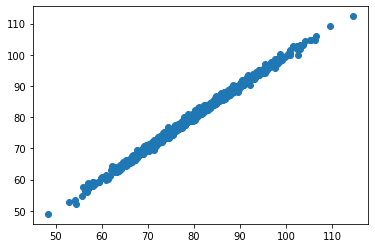

In [37]:
plt.scatter(y_test, y_predicted)
plt.show()

In [40]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mae', 'loss', 'mae'])


In [41]:
valmae = history.history.get('val_mae')
valmae[-1]

0.4957593083381653

In [42]:
[loss_ori, mae_ori] = MyRegressor.evaluate(x_test, y_test, batch_size=128, verbose=0)

#### Experimenting Features for ranking

In [65]:
Losses = np.zeros(P,)
MAEs = np.zeros(P,)
for i in range(P):
    
    temp_x_test = copy.deepcopy(x_test)
    temp_x_test[:,i] = np.zeros(1000,)
    [loss, mae] = MyRegressor.evaluate(temp_x_test, y_test, batch_size=128, verbose=0)
    Losses[i]=loss
    MAEs[i]=mae-mae_ori

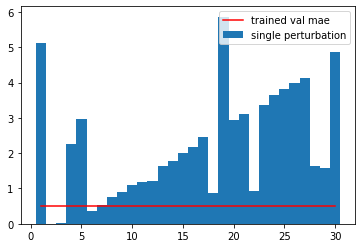

In [66]:
plt.figure
plt.bar(range(1,P+1), MAEs, 1, label='single perturbation')
plt.plot(range(1,P+1),valmae[-1]*np.ones(P,),'r', label='trained val mae')
plt.legend()
plt.show()

In [88]:
MAEs

array([5.12512842e+00, 4.36344743e-03, 3.33116949e-02, 2.26692739e+00,
       2.97362891e+00, 3.59268576e-01, 5.20810038e-01, 7.68034488e-01,
       9.07418638e-01, 1.10465088e+00, 1.19342294e+00, 1.20760253e+00,
       1.63946190e+00, 1.76840129e+00, 2.01571980e+00, 2.18745080e+00,
       2.45733729e+00, 8.79538327e-01, 5.86296907e+00, 2.95215145e+00,
       3.10330072e+00, 9.29906040e-01, 3.36826745e+00, 3.64682546e+00,
       3.82025638e+00, 3.97650877e+00, 4.11922947e+00, 1.63202897e+00,
       1.57098499e+00, 4.85986391e+00])

In [126]:
# Checking 2-way intereactions

In [68]:
Losses2 = np.zeros([P,P],)
MAEs2 = np.zeros([P,P],)
MAEs2_Corrected = np.zeros([P,P],)
MAEs2_Corrected2 = np.zeros([P,P],)
MAEs2_Corrected3 = np.zeros([P,P],)

for i in range(P):
    for j in range(P):
        temp_x_test = copy.deepcopy(x_test)
        temp_x_test[:,i] = 0
        temp_x_test[:,j] = 0
        [loss, mae] = MyRegressor.evaluate(temp_x_test, y_test, batch_size=128, verbose=0)
        Losses2[i][j] = loss
        MAEs2[i][j] = mae
        MAEs2_Corrected[i][j] = mae - (MAEs[i] + MAEs[j])
        MAEs2_Corrected2[i][j] = mae - mae_ori
        MAEs2_Corrected3[i][j] = mae - mae_ori - (MAEs[i] + MAEs[j])
            

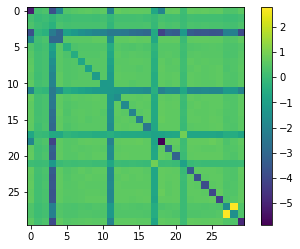

In [69]:
plt.imshow(MAEs2_Corrected3)
plt.colorbar()
#plt.clim(-10,2.2)
plt.show()

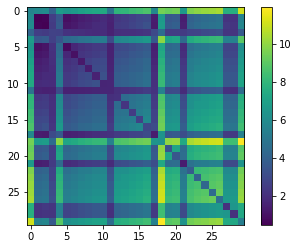

In [70]:
plt.imshow(MAEs2)
plt.colorbar()
plt.show()

In [71]:
np.mean(x_test[:,0])

5.348

In [72]:
x_test[0].shape

(30,)

#### Compressed Sensing for Epistatic Feature Finding

In [ ]:
# TODO: M = mxP*P/2

In [89]:
m=50
Losses = np.zeros(m,)
CSMAEs = np.zeros(m,)

#generate matrix M
Mtemp=[]


for i in range(m):
    
    tempindex = np.random.randint(0, high=P, size=5)
    Mtemp.append(tempindex)
    temp_x_test = copy.deepcopy(x_test)
    temp_x_test[:,tempindex] = 0

    [loss, mae] = MyRegressor.evaluate(temp_x_test, y_test, batch_size=128, verbose=0)
    Losses[i]=loss
    CSMAEs[i]=mae


# Make Measurement Matrix
M = np.zeros([m,P])
for i in range(m):
    M[i][Mtemp[i]] = 1.0
    

In [90]:
CSMAEs.shape

(50,)

In [52]:
import pickle
# Saving the objects:
with open('M_MAEs_V1.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([M, MAEs], f)

In [ ]:
import pickle
# Getting back the objects:
with open('M_MAEs_V1.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
    M, MAEs = pickle.load(f)

In [91]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import ARDRegression

In [92]:
M.shape

(50, 30)

In [93]:
#Solve LASSO or ARD
Pnew = CSMAEs-mae_ori
P_infer_list = []
L1norm=[]
L2norm=[]
L12tot=[]

for k in range(100):
    alp = np.logspace(-5, 1, num=100)
    #clf = Lasso(alpha=alp[k])
    clf = ARDRegression()
    clf.fit(M, Pnew)
    P_infer = clf.coef_
    P_infer_list.append(P_infer)
    L1norm.append(np.sum(np.abs(P_infer)))
    L2norm.append(np.sum((np.dot(M,P_infer)-Pnew)**2))
    L12tot.append(L2norm[-1] + alp[k]*L1norm[-1])

P_infer_array = np.asarray(P_infer_list)

#Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
#   normalize=False, positive=False, precompute=False, random_state=None,
#   selection='cyclic', tol=0.0001, warm_start=False)


In [ ]:
#plt.plot(np.log10(alp),L1norm)
plt.plot(np.log10(alp),L2norm)
#plt.plot(np.log10(alp),L12tot)
plt.show()

# save
#plt.savefig('M50_by5_Neuron_Ablations_Layer1_MSE_180628_V4.pdf', format='pdf', dpi=1200)

In [ ]:
plt.bar(range(1,P+1), P_infer_array[0,:])
plt.show()

In [ ]:
for k in range(P):
    plt.plot(np.log10(alp),P_infer_array[:,k])

#plt.plot(np.log10(alp),L2norm)
#plt.ylim([-0.02, 0.3])
plt.show()

# save
#plt.savefig('M50_by5_Neuron_Ablations_Layer1_SolutionTraces_180628_V4.pdf', format='pdf', dpi=1200)

In [ ]:
plt.imshow(M, cmap='gray')
plt.show()

# save
#plt.savefig('M50_by5_Neuron_Ablations_Layer1_RandomMeasurementMatrix_180628_V4.pdf', format='pdf', dpi=1200)